### Multi Agent architectures


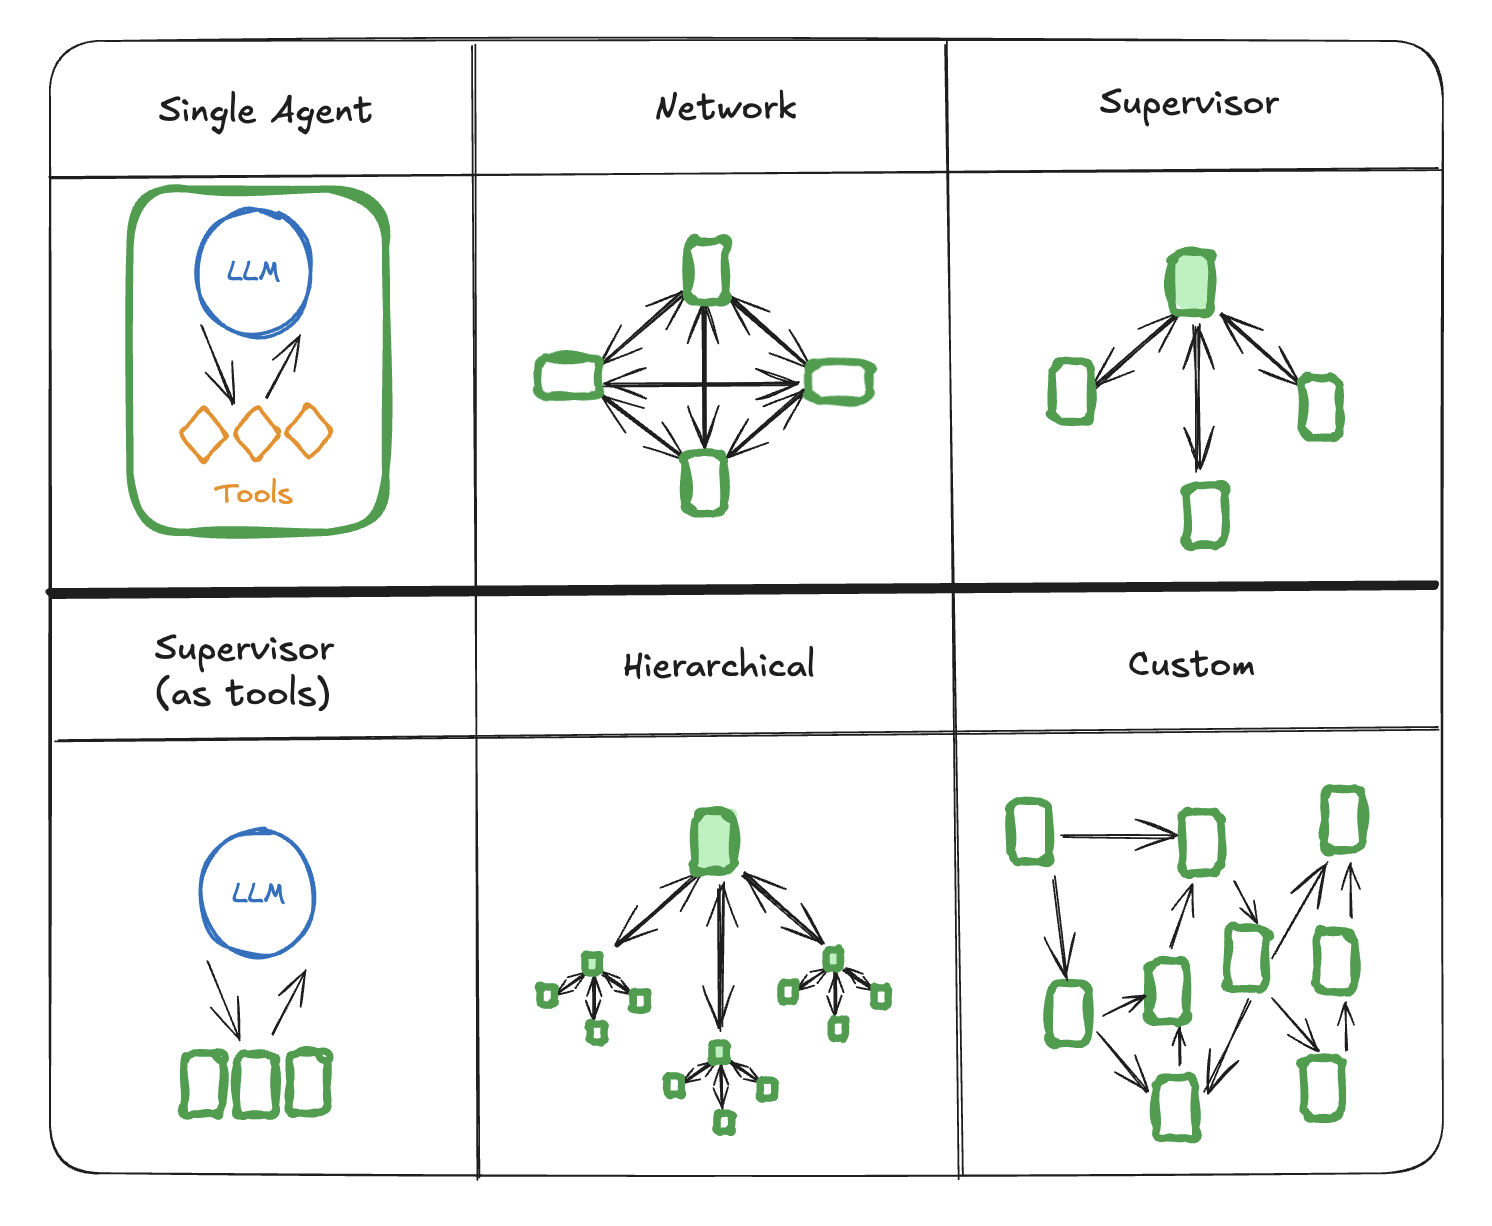

#### Here we will be dealing with Network / Collaborative architecture

- Network: Each agent can communicate with every other agent. Any agent can decide which other agent to call next and will work in collaborative manner.

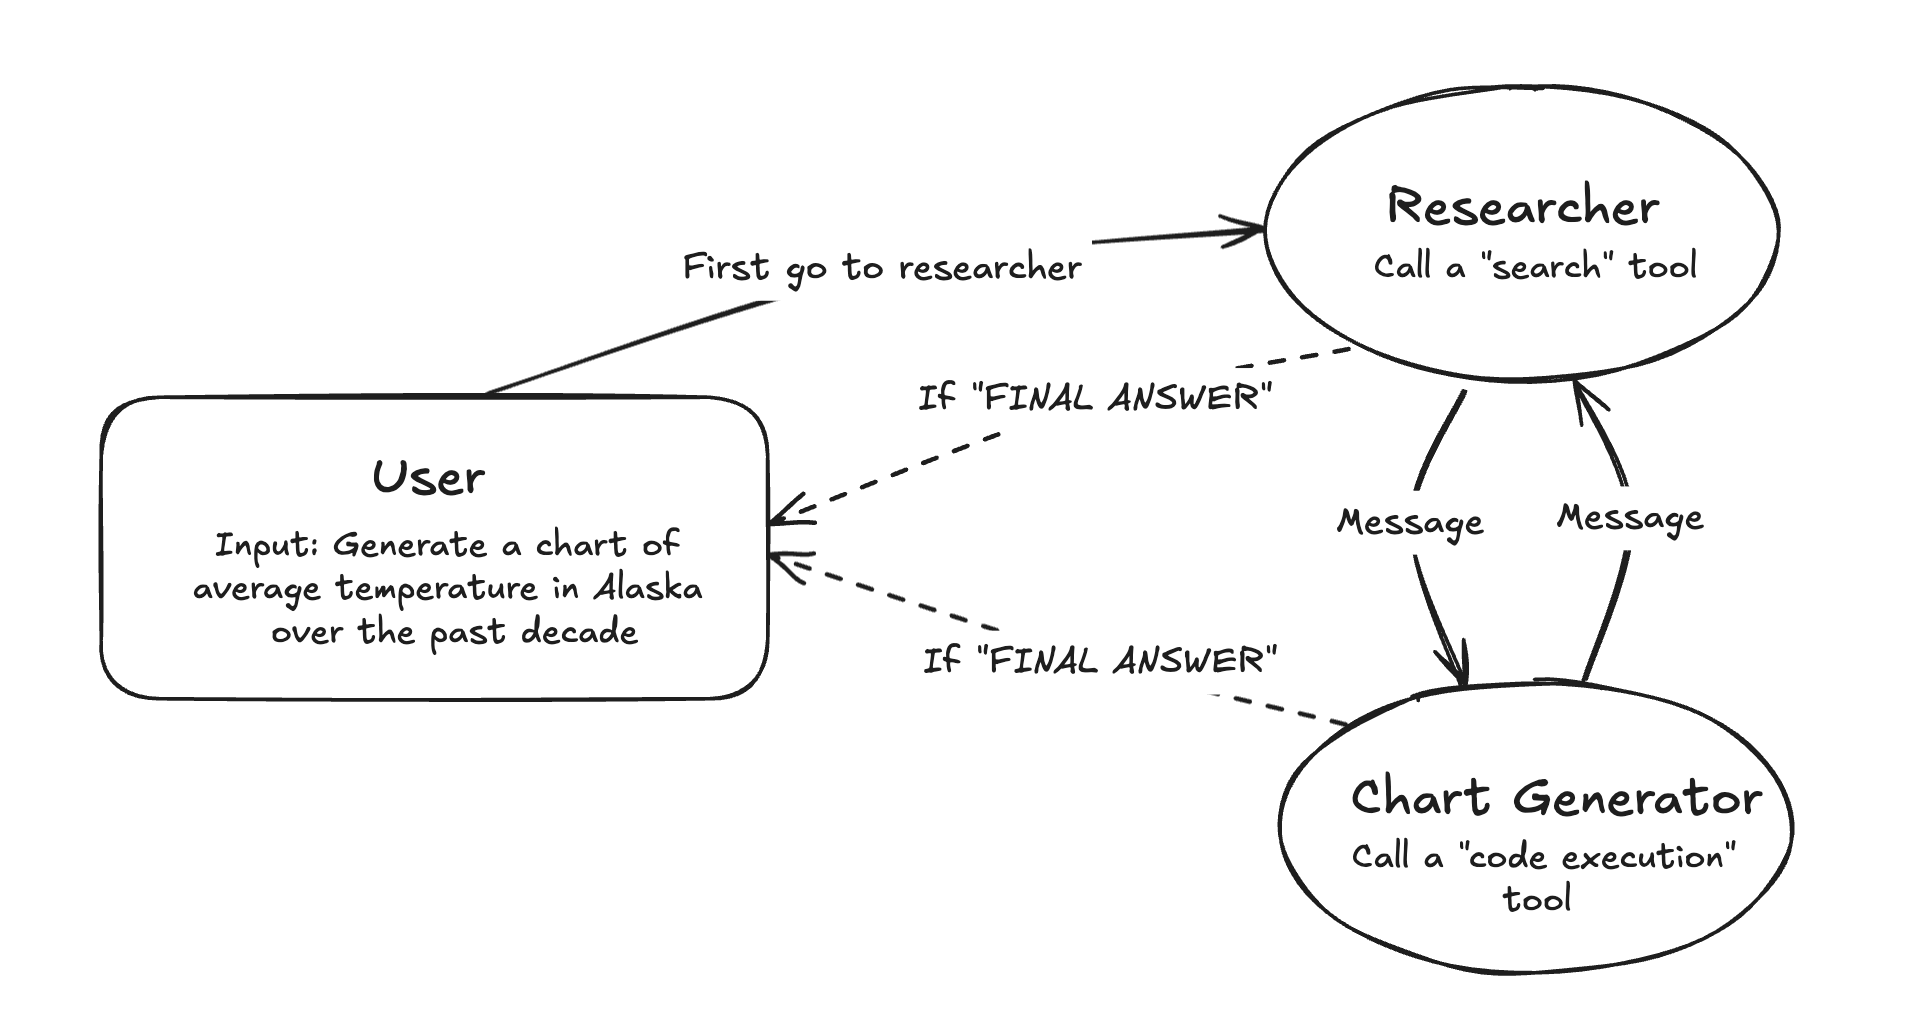

- Multiple agents (`Researcher`, `Chart Generator`) interact with reach other directly where the `researcher` might respond directly or delegate to the `chart generator` before returning a final answer.

- This is a Network Multi-Agent Architecture, where specialized agents (Researcher and Chart Generator) coordinate via messages to fulfill a user request. The system dynamically routes tasks between agents, allowing flexible and collaborative task-solving.

In [188]:
from dotenv import load_dotenv

load_dotenv()

True

##### Setting up LLM

In [189]:
# from langchain_groq import ChatGroq
# llm=ChatGroq(model="llama-3.1-8b-instant")
# llm.invoke("Hi, how are you?")

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

#### Definig Custom tools

In [190]:
from langchain_core.tools import tool
from langgraph.graph import StateGraph,MessagesState,START,END,add_messages

from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import TypedDict,List,Literal,Annotated,operator,Sequence

tavily_tool=TavilySearchResults(name="tavily_search_results_json")
tavily_tool.invoke("what is todays news about Illinois institute of Technology?")

[{'title': 'News | Illinois Institute of Technology',
  'url': 'https://www.iit.edu/news',
  'content': '## Manny Maceda, Global Business Leader and Culture Builder, to Receive Honorary Doctor of Management from Illinois Tech CHICAGO—May 17, 2025—Illinois Institute of Technology (Illinois Tech) will award Manny Maceda (CHE ’84), a visionary business executive and global management consultant, an Honorary Doctor of... CHICAGO—May 17, 2025—Illinois Institute of Technology (Illinois Tech) will award Gerald Chan, a renowned scientist, entrepreneur, and visionary leader in biotechnology and health care innovation, an... CHICAGO—May 17, 2025—Illinois Institute of Technology (Illinois Tech) will award Frank Naeymi-Rad (Ph.D. CS ’90), a trailblazer in medical informatics and health care technology, an Honorary Doctor of... CHICAGO—May 17, 2025—Illinois Institute of Technology (Illinois Tech) will award pioneering investment strategist Ralph Wanger an Honorary Doctor of Management, honoris caus

In [191]:
def get_next_node(latest_message,next)-> str:
    
    if "FINAL ANSWER" in latest_message:
        goto=END
    else:
        goto=next
    
    return goto

In [192]:
code1="x=10\ny=10\nz=5\nz=x+y+z\nprint(z)"
python_repl = PythonREPL()
python_repl.run(code1)



'25\n'

In [193]:
code = """
x = 5
y = x * 2
print(y)
"""
python_repl.run(code)

'10\n'

In [216]:
@tool
def REPL_Coder_tool(code: Annotated[str,"The python code to execute to generate your chart."] ):
      """Use this to execute python code. If you want to see the output of a value,
        you should print it out with `print(...)`. This is visible to the user."""
      repl=PythonREPL()
      res=repl.run(code)

      result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {res}"

      return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
    
    

    


<>:8: SyntaxWarning: invalid escape sequence '\`'
<>:8: SyntaxWarning: invalid escape sequence '\`'
<>:8: SyntaxWarning: invalid escape sequence '\`'
<>:8: SyntaxWarning: invalid escape sequence '\`'
C:\Users\divya\AppData\Local\Temp\ipykernel_24744\610655478.py:8: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {res}"
C:\Users\divya\AppData\Local\Temp\ipykernel_24744\610655478.py:8: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {res}"


In [217]:
REPL_Coder_tool

StructuredTool(name='REPL_Coder_tool', description='Use this to execute python code. If you want to see the output of a value,\n        you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.REPL_Coder_tool'>, func=<function REPL_Coder_tool at 0x0000022354D8A020>)

In [218]:
code = """
x = 5
y = x * 2
print(y)
"""
print(REPL_Coder_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


#### Setting up AgentState

In [195]:
from langgraph.graph import StateGraph,MessagesState,START,END,add_messages
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import HumanMessage
from langgraph.types import Command


from langchain_core.messages import BaseMessage



from pydantic import BaseModel

In [196]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], add_messages]

In [197]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f" {instruction}"
    )

#### Defining Agents

#### Agent 1 - Researcher

In [ ]:
def researcher_node(state:AgentState)-> Command[Literal["ChartGenerator_Agent","__end__"]]:

    print("*********** entered researcher node *****************")

    model=llm
    instructions="""You can only do research. You are working with a chart generator colleague. """
    prompt=make_system_prompt(instruction=instructions)
    tool=[tavily_tool]
    researcher_agent=create_react_agent(model=model,tools=tool,prompt=prompt)
    result=researcher_agent.invoke(state)

    last_message=result["messages"][-1]
    goto=get_next_node(last_message,"Chart_Generator")
    result["messages"][-1]=HumanMessage(content=result["messages"][-1].content,name="Research_Agent")

    print("$$$$$$$$$$$$ goto $$$$$$$$$$$$$$$$":,goto)
    


    return Command(update={"messages":result["messages"]} , goto=goto)

In [199]:
make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop. You can only do research. You are working with a chart generator colleague."

In [200]:
researcher_node({"messages":["UK's GDP over the past 3 years"]})

*********** entered researcher node *****************


Command(update={'messages': [HumanMessage(content="UK's GDP over the past 3 years", additional_kwargs={}, response_metadata={}, id='f20825cb-7a91-4884-81ee-d600bc3c9ec4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FrguEsgm7r1L5HCX6ZFEDrN9', 'function': {'arguments': '{"query":"UK GDP data 2021 2022 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 189, 'total_tokens': 218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BohyaJzVy5piQ2Ei4jlEOCo5gxtbl', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--99f934e9-70b5-4a6b-8249-8d3c73650608-0', tool_calls=[{'name': 'tavil

#### Agent 2 - Chart Generator

In [201]:
def chart_generator(state:AgentState)->Command[Literal["Research_Agent","__end__"]]:
      
    print("*********** entered chart generator node *****************")

    model=llm
    instructions=""" You can only generate charts. You are working with a researcher colleague."""
    prompt=make_system_prompt(instruction=instructions)
    tools=[REPL_Coder_tool]

    chart_generator_agent=create_react_agent(model=model,tools=tools,prompt=prompt)
    result=chart_generator_agent.invoke(state)

    print(result["messages"])
    last_message=result["messages"][-1]
    goto=get_next_node(last_message,"researcher_node")
    result["messsages"][-1]=HumanMessage(content=result["messages"][-1].content,name="ChartGenerator_Agent")


    return Command(update={"messages":result["messages"]},goto=goto)


In [202]:

make_system_prompt("You can only generate charts. You are working with a researcher colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop. You can only generate charts. You are working with a researcher colleague."

#### Defining multi-Agent workflow

In [203]:
graph=StateGraph(AgentState)

In [204]:
graph.add_node("Research_Agent",researcher_node)
graph.add_node("ChartGenerator_Agent",chart_generator)

graph.add_edge(START,"Research_Agent")
app=graph.compile()

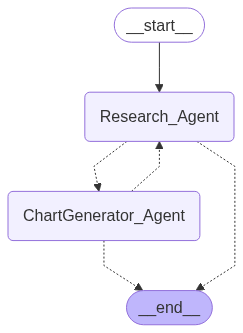

In [205]:
graph.compile()

In [206]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

*********** entered researcher node *****************


{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='7a614299-ee24-4c5d-a49a-4356796d76b1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Eb6Qrd2XZqEvBQnDZnWRFuvL', 'function': {'arguments': '{"query":"UK GDP past 3 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 206, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BohynQke8NdPk2uX0xVNJGlyhEcyy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b24e5bad-7eef-49e